# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [67]:
# ! python3 -m pip install SimpleITK==1.2.2 
# ! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
# ! unzip brainage-data.zip

# data directory
data_dir = './gm_volume3d/'

### Running on DoC lab machines

In [24]:
# data directory
data_dir = '/vol/lab/course/416/data/brain_age/'
data_dir = '/Users/brandelt/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [25]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

In [68]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

NameError: name 'meta_data_all' is not defined

### Set up a simple medical image viewer and import SimpleITK

In [69]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


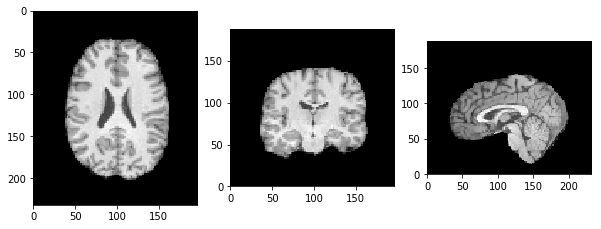

Brain mask (used in part A)


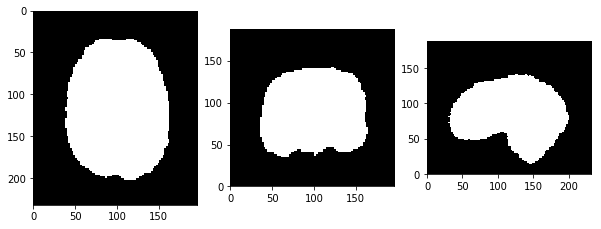

Spatially normalised grey matter maps (used in part B and C)


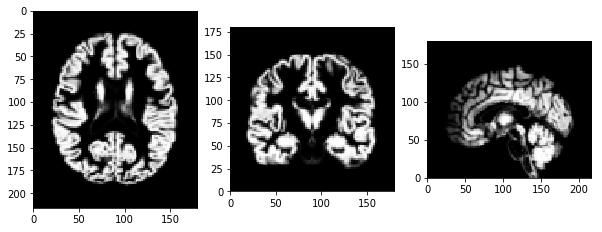

In [28]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [70]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [71]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [31]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cpu


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [10]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [11]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [ ]:
# LOAD ACTUAL TRAINING DATA
#dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

#### Visualise training example

Just to check how a training image looks like after pre-processing.

In [ ]:
sample = dataset_train.get_sample(0)
print(sample['img'])
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [ ]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return F.softmax(x, dim=1)

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

In [ ]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
#seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################

Plot features versus age.

In [ ]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################

Plot normalised features versus age.

In [ ]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [ ]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################

Error calculation and plotting

In [ ]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

In [72]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import os

path = 'combined_exist.tsv'

def read_meta(path=path):
    '''Correctly reads a .tsv} file into a numpy array'''
    data = []

    with open(path) as fd:
        rd = csv.reader(fd, delimiter=",", quotechar='"')
        data = []
        for idx, row in enumerate(rd):
            if idx == 0:
                continue
            data.append(row)

    data = np.array(data)

    return data


def get_file_path(patient_id, session_id):
    # sub-CC00050XX01_ses-7201_T2w_graymatter.nii.gz
    file_name = "sub-" + patient_id +"_ses-" + session_id + '_T2w_graymatter.nii.gz'
    file_path = data_dir + file_name

    return file_path

In [73]:
# Metadata categories
categories = {'gender': 3, 'birth_age': 4, 'weight': 5, 'scan_age': 7, 'scan_num': 8}
meta_column_idx = categories['scan_age']
test_size = 0.09
val_size = 0.1
random_state = 42

def split_data(meta_data, meta_column_idx):
    '''Split data into training and testing maintaining the same distribution for labels. Splitting is done
    based on the task and the target labels.
    :param meta_data: meta_data that is going to be split.
    :returns: Train or test meta_data.'''

    _, bins = np.histogram(meta_data[:, meta_column_idx].astype(float), bins='doane')
    y_binned = np.digitize(meta_data[:, meta_column_idx].astype(float), bins)

    X_train, X_test, y_train, y_test = train_test_split(meta_data, meta_data[:, meta_column_idx],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y_binned)
    if val_size > 0:
        _, bins = np.histogram(X_train[:, meta_column_idx].astype(float), bins='doane')
        y_binned = np.digitize(X_train[:, meta_column_idx].astype(float), bins)

        X_train, X_val, y_train, y_test = train_test_split(X_train, X_train[:, meta_column_idx],
                                                            test_size=val_size,
                                                            random_state=random_state,
                                                            stratify=y_binned)

    return X_train, X_val, X_test

In [81]:
# 1. Read the data
meta_data = read_meta()

# 2. Split the data
X_train, X_val, X_test = split_data(meta_data, meta_column_idx)


# 3. Iterate through all patient ids
gm_filenames = []
ages = []
for idx, patient_id in enumerate(meta_data[:, 1]):
    file_path = get_file_path(patient_id, meta_data[idx, 2])
    if os.path.isfile(file_path):
        gm_filenames.append(file_path)
        ages.append(float(meta_data[idx, meta_column_idx]))

        # READ NIFTI
        # Do this inside the Dataset Class
    

In [146]:
########################################
# ADD YOUR CODE HERE
########################################

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

# meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')

# 1. Get train meta data
# IDs = meta_data_reg_train['subject_id'].tolist()
# ages = meta_data_reg_train['age'].tolist()

# 2. Grey matter map filenames
# gm_filenames = [data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz' for ID in IDs]
variances = [i for i in range(10)]

class PCADataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, ages, img_spacing, img_size, smooth, edge=False, sharpen=False):
        self.samples = []
        self.img_names = []
        self.ages = ages

        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            
            # 1. Get image
            img_path = file_list_img[idx]
            img = sitk.Cast(sitk.ReadImage(img_path), sitk.sitkFloat32)

            # 2. Pre-process the image
            img = resample_image(img, img_spacing, img_size, is_label=False)
            
            if smooth in variances:
                img = sitk.DiscreteGaussian(img, smooth)

            elif smooth == 'diffusion':
                img = sitk.GradientAnisotropicDiffusion(img)
                
            if edge:
                img = sitk.SobelEdgeDetection(img)

            if sharpen:
                img_sm = sitk.DiscreteGaussian(img, 1)
                a = img - img_sm
                img = img + a * 2               
                
            # 3. Append to the samples list
            self.samples.append(img)
            self.img_names.append(os.path.basename(img_path)) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]
        image = torch.from_numpy(sitk.GetArrayFromImage(sample)).unsqueeze(0)

        return image
    
    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]
    
    def split_data(self):
        
        numpy_samples = []
        
        for sample in self.samples:
            numpy_samples.append(sitk.GetArrayFromImage(sample).flatten())
        
        numpy_samples = np.array(numpy_samples)
        
        X_train, X_test, y_train, y_test = train_test_split(numpy_samples, self.ages, test_size=0.50, random_state=42)
        return X_train, X_test, y_train, y_test
    
    def get_data(self):
        numpy_samples = []
    
        for sample in self.samples:
            numpy_samples.append(sitk.GetArrayFromImage(sample).flatten())
        
        return np.array(numpy_samples), self.ages


In [157]:
data = PCADataset(gm_filenames[0:2], ages, [1, 1, 1], [130 for i in range(3)], 1)

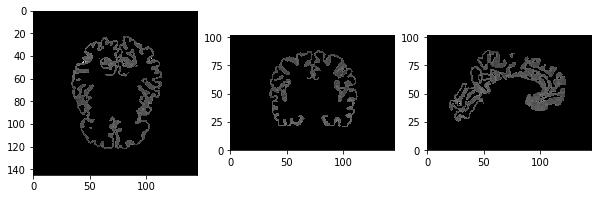

In [158]:
sample_image = sitk.ReadImage(gm_filenames[8])
display_image(sample_image)

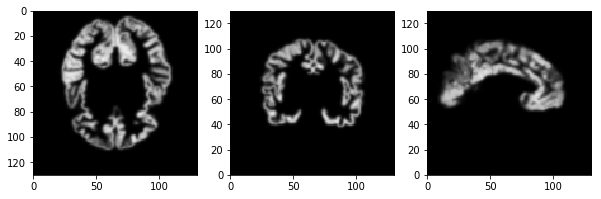

In [159]:
display_image(data.get_sample(0))

In [162]:
data = PCADataset(gm_filenames, ages, [1, 1, 1], [130 for i in range(3)], 1)

### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [163]:
########################################
# ADD YOUR CODE HERE
########################################

from sklearn.decomposition import PCA

def PCA_process(X_train, X_test, y_train, y_test, n_components):
    pca1 = PCA(n_components=n_components)
    pca2 = PCA(n_components=n_components)
    pca1.fit(X_train)
    pca2.fit(X_test)

    # Fold 1 : fit onto X_train
    X_train1 = pca1.transform(X_train)
    X_test1 = pca1.transform(X_test)
    y_train1 = y_train
    y_test1 = y_test

    # Fold 2 : fit onto X_test
    X_test2 = pca2.transform(X_train)
    X_train2 = pca2.transform(X_test)
    y_train2 = y_test
    y_test2 = y_train
    
    return X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2


### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [84]:
# Prepare datasets with different processing for {Gaussian Variance, Number of PCA Components}:
datasets = []

for sharpen in [True, False]:
    for edge in [True, False]:
        for gaussian_smooth in [5, 6, 7, 8, 9, 10, 'diffusion']:
            for n_components in [0.8, 0.85, 0.9, 0.95]:
                dataset = PCADataset(gm_filenames, ages, img_spacing, img_size, gaussian_smooth, edge=edge, sharpen=sharpen)
                X_train, X_test, y_train, y_test = dataset.split_data()
                X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = PCA_process(X_train, X_test, y_train, y_test, n_components)

                datasets.append((X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2))    

NameError: name 'img_spacing' is not defined

In [55]:
# Record datasets' characteristics
datasets_descriptions = {}
idx = 0
for sharpen in [True, False]:
    for edge in [True, False]:
        for gaussian_smooth in [3, 4, 5, 6, 7, 8, 'diffusion']:
            for n_components in [0.8, 0.85, 0.9, 0.95]:
                datasets_descriptions[idx] = (gaussian_smooth, n_components, edge, sharpen)
                idx+=1

# 1. SVR Regression: RBF

In [56]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

results = {}

# Run extensive grid search
for idx, dataset in enumerate(datasets):
    
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = dataset
    
    av_per_dataset = []

    for C in [1e5, 5e5, 1e6, 5e6, 1e7, 5e7]:
        for gamma in [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
            
            clf = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=.1)

            for cv in range(1, 3):
                if cv == 1:
                    clf.fit(X_train1, y_train1)
                    y_pred1 = clf.predict(X_test1)
                    mean1 = mean_absolute_error(y_test1, y_pred1)

                else:
                    clf.fit(X_train2, y_train2)
                    y_pred2 = clf.predict(X_test2)
                    mean2 = mean_absolute_error(y_test2, y_pred2)

            mean_error = (mean1 + mean2) / 2
            results[mean_error] = (idx, C, gamma)
            av_per_dataset.append(mean_error)
    
    print('Dataset {} --> Minimum Error: {}'.format(idx, np.min(av_per_dataset)))
    
best_error = np.min(list(results.keys()))
print('Best result: {}'.format(best_error))
print('Best dataset: {}'.format(results[best_error]))

Dataset 0 --> Minimum Error: 5.382100036103164
Dataset 1 --> Minimum Error: 5.304125056942558
Dataset 2 --> Minimum Error: 5.337901056246922
Dataset 3 --> Minimum Error: 5.306343573434205
Dataset 4 --> Minimum Error: 5.360449151541875
Dataset 5 --> Minimum Error: 5.297942740244676
Dataset 6 --> Minimum Error: 5.312736380904953
Dataset 7 --> Minimum Error: 5.274795675117068
Dataset 8 --> Minimum Error: 5.33922543204406
Dataset 9 --> Minimum Error: 5.279652524007767
Dataset 10 --> Minimum Error: 5.262537340515125
Dataset 11 --> Minimum Error: 5.2518048179461445
Dataset 12 --> Minimum Error: 5.312760972844595
Dataset 13 --> Minimum Error: 5.2829147385954425
Dataset 14 --> Minimum Error: 5.251428696543151
Dataset 15 --> Minimum Error: 5.245904811900345
Dataset 16 --> Minimum Error: 5.324576184266013
Dataset 17 --> Minimum Error: 5.25961886250685
Dataset 18 --> Minimum Error: 5.204416291772683
Dataset 19 --> Minimum Error: 5.228745143495804
Dataset 20 --> Minimum Error: 5.501188865086411
Da

# 2. SGD Regression

In [58]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

results = {}

# Run extensive grid search
for idx, dataset in enumerate(datasets):
    
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = dataset
    av_per_dataset = []
        
    for max_iter in [1e6, 1e7, 5e7]:
        for tol in [1e-1, 1e-2, 1e-4]:
            
            clf = SGDRegressor(max_iter=max_iter, tol=1e-3)

            for cv in range(1, 3):
                if cv == 1:
                    clf.fit(X_train1, y_train1)
                    y_pred1 = clf.predict(X_test1)
                    mean1 = mean_absolute_error(y_test1, y_pred1)

                else:
                    clf.fit(X_train2, y_train2)
                    y_pred2 = clf.predict(X_test2)
                    mean2 = mean_absolute_error(y_test2, y_pred2)

            mean_error = (mean1 + mean2) / 2
            results[mean_error] = (idx, max_iter, tol)
            av_per_dataset.append(mean_error)
            
    print('Dataset {} --> Minimum Error: {}'.format(idx, np.min(av_per_dataset)))
    
best_error = np.min(list(results.keys()))
print('Best result: {}'.format(best_error))
print('Best dataset: {}'.format(results[best_error]))

Dataset 0 --> Minimum Error: 127273569207236.97
Dataset 1 --> Minimum Error: 103011530099102.58
Dataset 2 --> Minimum Error: 126747860393686.33
Dataset 3 --> Minimum Error: 122331011894357.0
Dataset 4 --> Minimum Error: 89371712030746.89
Dataset 5 --> Minimum Error: 80335626000740.34
Dataset 6 --> Minimum Error: 101158863382863.95
Dataset 7 --> Minimum Error: 88733039017144.4
Dataset 8 --> Minimum Error: 76456425014439.8
Dataset 9 --> Minimum Error: 79671047863095.44
Dataset 10 --> Minimum Error: 86271456553515.33
Dataset 11 --> Minimum Error: 96536752390651.47
Dataset 12 --> Minimum Error: 56484469113020.49
Dataset 13 --> Minimum Error: 68117719451219.47
Dataset 14 --> Minimum Error: 81683210621994.73
Dataset 15 --> Minimum Error: 78607700314541.73
Dataset 16 --> Minimum Error: 58892150995612.28
Dataset 17 --> Minimum Error: 65004621425645.71
Dataset 18 --> Minimum Error: 55091341394260.44
Dataset 19 --> Minimum Error: 65258249234122.42
Dataset 20 --> Minimum Error: 264676120944226.9


# 3. Gaussian Process

In [60]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

results = {}

# Run extensive grid search
for idx, dataset in enumerate(datasets):
    
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = dataset
    av_per_dataset = []
    
    for kernel in [DotProduct(), WhiteKernel(), RBF()]:
        

            clf = GaussianProcessRegressor(kernel=kernel, alpha=2.5, random_state=0)

            for cv in range(1, 3):
                if cv == 1:
                    clf.fit(X_train1, y_train1)
                    y_pred1 = clf.predict(X_test1)
                    mean1 = mean_absolute_error(y_test1, y_pred1)

                else:
                    clf.fit(X_train2, y_train2)
                    y_pred2 = clf.predict(X_test2)
                    mean2 = mean_absolute_error(y_test2, y_pred2)

            mean_error = (mean1 + mean2) / 2
            results[mean_error] = (idx, kernel)
            av_per_dataset.append(mean_error)
            
    print('Dataset {} --> Minimum Error: {}'.format(idx, np.min(av_per_dataset)))
    
best_error = np.min(list(results.keys()))
print('Best result: {}'.format(best_error))
print('Best dataset: {}'.format(results[best_error]))

Dataset 0 --> Minimum Error: 5.46838328803071
Dataset 1 --> Minimum Error: 5.454171660726492
Dataset 2 --> Minimum Error: 5.440135653460054
Dataset 3 --> Minimum Error: 5.479201138324734
Dataset 4 --> Minimum Error: 5.506442142166263
Dataset 5 --> Minimum Error: 5.515498123373181
Dataset 6 --> Minimum Error: 5.5059108825549865
Dataset 7 --> Minimum Error: 5.479847042177737
Dataset 8 --> Minimum Error: 5.5381342152329225
Dataset 9 --> Minimum Error: 5.465995930838018
Dataset 10 --> Minimum Error: 5.470663431520833
Dataset 11 --> Minimum Error: 5.456256138155436
Dataset 12 --> Minimum Error: 5.4901289914517
Dataset 13 --> Minimum Error: 5.439493641987496
Dataset 14 --> Minimum Error: 5.403195401850978
Dataset 15 --> Minimum Error: 5.461581863177429
Dataset 16 --> Minimum Error: 5.52772336901422
Dataset 17 --> Minimum Error: 5.410347206369388
Dataset 18 --> Minimum Error: 5.3885046699037815
Dataset 19 --> Minimum Error: 5.422879935825378
Dataset 20 --> Minimum Error: 5.761802546626574
Dat

# 4. Adaboost

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

results = {}

# Run extensive grid search
for idx, dataset in enumerate(datasets):
    
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = dataset
    av_per_dataset = []
    
    for n_estimators in [50, 100, 150, 200]:
        for max_depth in [1, 2, 10, 50]:
            for loss in ['ls', 'lad']:

                clf = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=0.1, max_depth=max_depth, random_state=0, loss=loss)

                for cv in range(1, 3):
                    if cv == 1:
                        clf.fit(X_train1, y_train1)
                        y_pred1 = clf.predict(X_test1)
                        mean1 = mean_absolute_error(y_test1, y_pred1)

                    else:
                        clf.fit(X_train2, y_train2)
                        y_pred2 = clf.predict(X_test2)
                        mean2 = mean_absolute_error(y_test2, y_pred2)

                mean_error = (mean1 + mean2) / 2
                results[mean_error] = (idx, n_estimators, max_depth, loss)
                av_per_dataset.append(mean_error)
            
    print('Dataset {} --> Minimum Error: {}'.format(idx, np.mean(av_per_dataset)))
    
best_error = np.min(list(results.keys()))
print('Best result: {}'.format(best_error))
print('Best dataset: {}'.format(results[best_error]))

Dataset 0 --> Minimum Error: 7.580847103068601
Dataset 1 --> Minimum Error: 7.607674322522606
Dataset 2 --> Minimum Error: 7.6728705953301475
Dataset 3 --> Minimum Error: 7.703041561229206
Dataset 4 --> Minimum Error: 7.728791871041337
Dataset 5 --> Minimum Error: 7.720767270517097
Dataset 6 --> Minimum Error: 7.774317607680176
Dataset 7 --> Minimum Error: 7.7612593915327786
Dataset 8 --> Minimum Error: 7.60114602924336
Dataset 9 --> Minimum Error: 7.5993802398185775
Dataset 10 --> Minimum Error: 7.565890316636358
Dataset 11 --> Minimum Error: 7.618729752286193
Dataset 12 --> Minimum Error: 7.739004909686235
Dataset 13 --> Minimum Error: 7.781190604499638
Dataset 14 --> Minimum Error: 7.777440607032206
Dataset 15 --> Minimum Error: 7.855088800719192
Dataset 16 --> Minimum Error: 7.591449746961828
Dataset 17 --> Minimum Error: 7.653651051399937
Dataset 18 --> Minimum Error: 7.6975725856927735
Dataset 19 --> Minimum Error: 7.796904802232534
Dataset 20 --> Minimum Error: 7.901674240296836

# 5. ElasticNet

In [62]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

results = {}

# Run extensive grid search
for idx, dataset in enumerate(datasets):
    
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = dataset
    av_per_dataset = []

    clf = ElasticNet(random_state=0)

    for cv in range(1, 3):
        if cv == 1:
            clf.fit(X_train1, y_train1)
            y_pred1 = clf.predict(X_test1)
            mean1 = mean_absolute_error(y_test1, y_pred1)

        else:
            clf.fit(X_train2, y_train2)
            y_pred2 = clf.predict(X_test2)
            mean2 = mean_absolute_error(y_test2, y_pred2)

    mean_error = (mean1 + mean2) / 2
    results[mean_error] = (idx)
    av_per_dataset.append(mean_error)
            
    print('Dataset {} --> Minimum Error: {}'.format(idx, np.mean(av_per_dataset)))
    
best_error = np.min(list(results.keys()))
print('Best result: {}'.format(best_error))
print('Best dataset: {}'.format(results[best_error]))

Dataset 0 --> Minimum Error: 5.414564022064209
Dataset 1 --> Minimum Error: 5.408758647918701
Dataset 2 --> Minimum Error: 5.414515266418457
Dataset 3 --> Minimum Error: 5.4302572059631355
Dataset 4 --> Minimum Error: 5.399191265106201
Dataset 5 --> Minimum Error: 5.400780704498291
Dataset 6 --> Minimum Error: 5.402637393951416
Dataset 7 --> Minimum Error: 5.40775496673584
Dataset 8 --> Minimum Error: 5.420924827575684
Dataset 9 --> Minimum Error: 5.377507587432861
Dataset 10 --> Minimum Error: 5.383684936523437
Dataset 11 --> Minimum Error: 5.396484432220459
Dataset 12 --> Minimum Error: 5.431288661956787
Dataset 13 --> Minimum Error: 5.368023735046387
Dataset 14 --> Minimum Error: 5.363105068206787
Dataset 15 --> Minimum Error: 5.383374114990234
Dataset 16 --> Minimum Error: 5.43862191772461
Dataset 17 --> Minimum Error: 5.362156158447266
Dataset 18 --> Minimum Error: 5.348048351287842
Dataset 19 --> Minimum Error: 5.372354221343993
Dataset 20 --> Minimum Error: 5.570928226470947
Dat

# 6. Ridge Regression

In [63]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

results = {}

# Run extensive grid search
for idx, dataset in enumerate(datasets):
    
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = dataset
    av_per_dataset = []
    
    for alpha in [0.01, 0.1, 1, 2, 10]:

                clf = Ridge(alpha=alpha)

                for cv in range(1, 3):
                    if cv == 1:
                        clf.fit(X_train1, y_train1)
                        y_pred1 = clf.predict(X_test1)
                        mean1 = mean_absolute_error(y_test1, y_pred1)

                    else:
                        clf.fit(X_train2, y_train2)
                        y_pred2 = clf.predict(X_test2)
                        mean2 = mean_absolute_error(y_test2, y_pred2)

                mean_error = (mean1 + mean2) / 2
                results[mean_error] = (idx)
                av_per_dataset.append(mean_error)
            
    print('Dataset {} --> Minimum Error: {}'.format(idx, np.mean(av_per_dataset)))
    
best_error = np.min(list(results.keys()))
print('Best result: {}'.format(best_error))
print('Best dataset: {}'.format(results[best_error]))

Dataset 0 --> Minimum Error: 5.408331184387206
Dataset 1 --> Minimum Error: 5.403614073944093
Dataset 2 --> Minimum Error: 5.410875025939941
Dataset 3 --> Minimum Error: 5.4274887992858885
Dataset 4 --> Minimum Error: 5.393387297821045
Dataset 5 --> Minimum Error: 5.395391487121581
Dataset 6 --> Minimum Error: 5.399073442840576
Dataset 7 --> Minimum Error: 5.403342036437988
Dataset 8 --> Minimum Error: 5.413015605926514
Dataset 9 --> Minimum Error: 5.370199993896485
Dataset 10 --> Minimum Error: 5.377205645751953
Dataset 11 --> Minimum Error: 5.388079521942139
Dataset 12 --> Minimum Error: 5.425931331634521
Dataset 13 --> Minimum Error: 5.361802004241943
Dataset 14 --> Minimum Error: 5.3572384658813474
Dataset 15 --> Minimum Error: 5.3773957435607915
Dataset 16 --> Minimum Error: 5.429965057373048
Dataset 17 --> Minimum Error: 5.350098393249512
Dataset 18 --> Minimum Error: 5.335946710968018
Dataset 19 --> Minimum Error: 5.360987696075439
Dataset 20 --> Minimum Error: 5.56671703491211


# 7. Lasso Regression

In [64]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

results = {}

# Run extensive grid search
for idx, dataset in enumerate(datasets):
    
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = dataset
    av_per_dataset = []
    
    for alpha in [0.01, 0.1, 1, 2, 10]:

                clf = Lasso(alpha=alpha)

                for cv in range(1, 3):
                    if cv == 1:
                        clf.fit(X_train1, y_train1)
                        y_pred1 = clf.predict(X_test1)
                        mean1 = mean_absolute_error(y_test1, y_pred1)

                    else:
                        clf.fit(X_train2, y_train2)
                        y_pred2 = clf.predict(X_test2)
                        mean2 = mean_absolute_error(y_test2, y_pred2)

                mean_error = (mean1 + mean2) / 2
                results[mean_error] = (idx)
                av_per_dataset.append(mean_error)
            
    print('Dataset {} --> Minimum Error: {}'.format(idx, np.mean(av_per_dataset)))
    
best_error = np.min(list(results.keys()))
print('Best result: {}'.format(best_error))
print('Best dataset: {}'.format(results[best_error]))

Dataset 0 --> Minimum Error: 5.451950229644775
Dataset 1 --> Minimum Error: 5.4458846115112305
Dataset 2 --> Minimum Error: 5.449239321899414
Dataset 3 --> Minimum Error: 5.464943202972412
Dataset 4 --> Minimum Error: 5.446696116638184
Dataset 5 --> Minimum Error: 5.447672121429444
Dataset 6 --> Minimum Error: 5.446874278259277
Dataset 7 --> Minimum Error: 5.452343980407716
Dataset 8 --> Minimum Error: 5.469857907867431
Dataset 9 --> Minimum Error: 5.431301292419434
Dataset 10 --> Minimum Error: 5.434721024322511
Dataset 11 --> Minimum Error: 5.447334926605225
Dataset 12 --> Minimum Error: 5.479952114105225
Dataset 13 --> Minimum Error: 5.424337221527099
Dataset 14 --> Minimum Error: 5.419879647827149
Dataset 15 --> Minimum Error: 5.437457080078126
Dataset 16 --> Minimum Error: 5.492045195007324
Dataset 17 --> Minimum Error: 5.426443319702149
Dataset 18 --> Minimum Error: 5.414243183135987
Dataset 19 --> Minimum Error: 5.432519254302979
Dataset 20 --> Minimum Error: 5.591715050506592
D

# Best Model: SVM-RBF

In [70]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import seaborn as sns

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')

# 1. Get test meta data
IDs = meta_data_reg_test['subject_id'].tolist()
ages_test = meta_data_reg_test['age'].tolist()

# 2. Grey matter map filenames
gm_filenames_test = [data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz' for ID in IDs]

img_sizes = [[60, 60, 60], [50, 50, 50], [40, 40, 40], [60, 60, 50], [60, 60, 40]]
img_spacing = [3, 3, 3]

# Cross validate for image size
for img_size in img_sizes:
    # RESULTS: Best data idx = 71-75. smoothening = 6, edge filter, 0.90 PCA
    gaussian_smooth = 6
    edge = True
    sharpen = False
    n_components = 0.9

    dataset = PCADataset(gm_filenames, ages, img_spacing, img_size, gaussian_smooth, edge=edge, sharpen=sharpen)
    X_train, X_test, y_train, y_test = dataset.split_data()
    X_train1, y_train1, X_test1, y_test1, X_train2, y_train2, X_test2, y_test2 = PCA_process(X_train, X_test, y_train, y_test, n_components)

    # 2. Initialise the BEST MODEL
    C = 50000000.0
    gamma = 1e-07
    clf = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=.1)

    for cv in range(1, 3):
        if cv == 1:
            clf.fit(X_train1, y_train1)
            y_pred1 = clf.predict(X_test1)
            mean1 = mean_absolute_error(y_test1, y_pred1)

        else:
            clf.fit(X_train2, y_train2)
            y_pred2 = clf.predict(X_test2)
            mean2 = mean_absolute_error(y_test2, y_pred2)

    mean_error = (mean1 + mean2) / 2
    
    print('{} ===> {}'.format(img_size, mean_error))
    


[60, 60, 60] ===> 5.173014254534557



[50, 50, 50] ===> 5.3285463029752



[40, 40, 40] ===> 5.54412087705942



[60, 60, 50] ===> 5.195939545114845



[60, 60, 40] ===> 5.176768036442386


In [165]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import seaborn as sns

# RESULTS: Best data idx = 71-75. smoothening = 6, edge filter, 0.90 PCA
# gaussian_smooth = 6
# edge = True
# sharpen = False
n_components = 0.9
# img_size = [60, 60, 60]

# dataset_train = PCADataset(gm_filenames, ages, img_spacing, img_size, gaussian_smooth, edge=edge, sharpen=sharpen)
# dataset_test = PCADataset(gm_filenames_test, ages_test, img_spacing, img_size, gaussian_smooth, edge=edge, sharpen=sharpen)
# X_train, y_train = dataset_train.get_data()
# X_test, y_test = dataset_test.get_data()
X_train, X_test, y_train, y_test = data.split_data()

pca = PCA(n_components=n_components)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


# 2. Initialise the BEST MODEL
C = 50000000.0
gamma = 1e-07

clf = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=.1)
clf.fit(X_train, y_train)


# 3. Record the results
predicted = clf.predict(X_test)
# y_test = meta_data_reg_test['age'].values.reshape(-1,)

KeyboardInterrupt: 

Error calculation and plotting

mean absolute error: 4.5787
r2 score: 0.9187


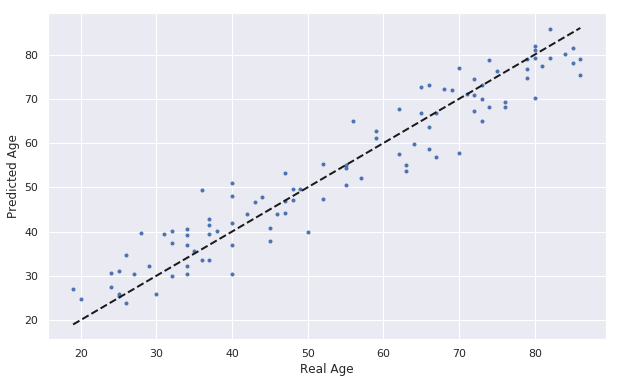

In [74]:
print('mean absolute error: {0:.4f}'.format(mean_absolute_error(y_test,predicted)))
print('r2 score: {0:.4f}'.format(r2_score(y_test,predicted)))

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted, marker='.')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()



## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################

Error calculation and plotting

In [ ]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()